In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime


In [5]:
df = pd.read_csv("/content/online_retail 2.csv")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.shape
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
# Remove rows with missing CustomerID
df = df.dropna(subset=["CustomerID"])

# Remove negative or zero quantity
df = df[df["Quantity"] > 0]

# Remove negative or zero price
df = df[df["UnitPrice"] > 0]


In [8]:
df.shape


(397884, 8)

In [10]:
#Convert InvoiceDate to Date Format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["Day"] = df["InvoiceDate"].dt.day



In [12]:
#Create Total Sales Column
df["Sales"] = df["Quantity"] * df["UnitPrice"]
df[["Quantity", "UnitPrice", "Sales"]].head()



,Quantity,UnitPrice,Sales
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


In [14]:
#Create Monthly Sales Data (For Forecasting)
monthly_sales = (
    df
    .groupby(pd.Grouper(key="InvoiceDate", freq="M"))
    .agg({"Sales": "sum"})
    .reset_index()
)
#Check Output
monthly_sales.head()



/tmp/ipython-input-3523280599.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(key="InvoiceDate", freq="M"))


,InvoiceDate,Sales
0,2010-12-31,572713.890
1,2011-01-31,569445.040
2,2011-02-28,447137.350
3,2011-03-31,595500.760
4,2011-04-30,469200.361


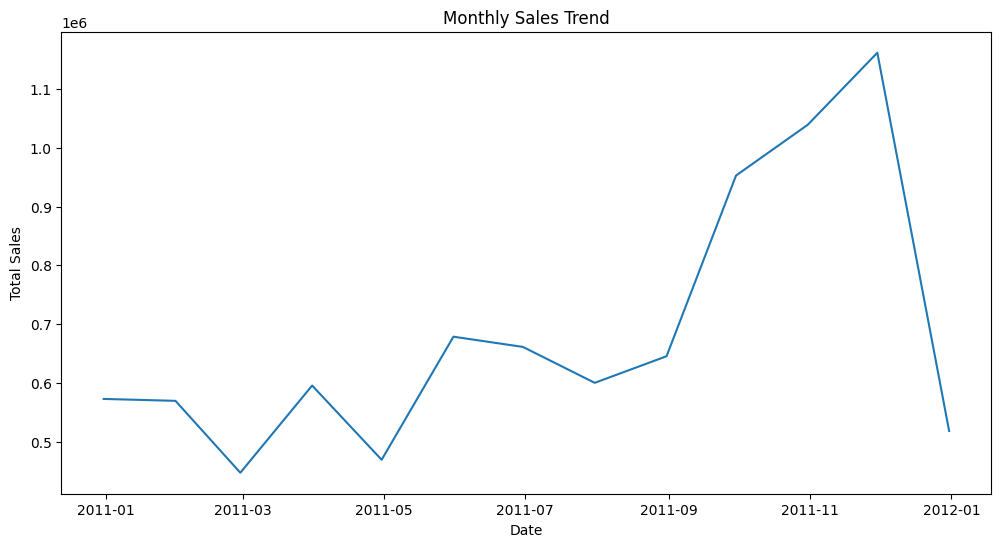

In [15]:
#Visualize Monthly Sales Trend
plt.figure(figsize=(12,6))
plt.plot(monthly_sales["InvoiceDate"], monthly_sales["Sales"])
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()


In [16]:
monthly_sales.to_csv("monthly_sales_cleaned.csv", index=False)


In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [19]:
#Set date as index
ts = monthly_sales.copy()
ts.set_index("InvoiceDate", inplace=True)
#check
ts.head()



,Sales
InvoiceDate,
2010-12-31,572713.890
2011-01-31,569445.040
2011-02-28,447137.350
2011-03-31,595500.760
2011-04-30,469200.361


In [22]:
#Train–Test Split (Time-Based)
train_size = int(len(ts) * 0.8)

train = ts.iloc[:train_size]
test = ts.iloc[train_size:]
#Check sizes:
train.shape, test.shape



((10, 1), (3, 1))

In [23]:
#Build ARIMA Model
model = ARIMA(train["Sales"], order=(1,1,1))
model_fit = model.fit()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [24]:
#Forecast Sales
forecast = model_fit.forecast(steps=len(test))

#Convert to DataFrame:
forecast_df = pd.DataFrame({
    "Actual": test["Sales"].values,
    "Forecast": forecast.values
}, index=test.index)

forecast_df.head()


,Actual,Forecast
InvoiceDate,,
2011-10-31,1039318.79,898117.170414
2011-11-30,1161817.38,890308.064975
2011-12-31,518192.79,889193.650180


In [25]:
#Evaluate Forecast Accuracy
mae = mean_absolute_error(forecast_df["Actual"], forecast_df["Forecast"])
rmse = np.sqrt(mean_squared_error(forecast_df["Actual"], forecast_df["Forecast"]))

mae, rmse


(261237.2649304409, np.float64(277666.9730532167))

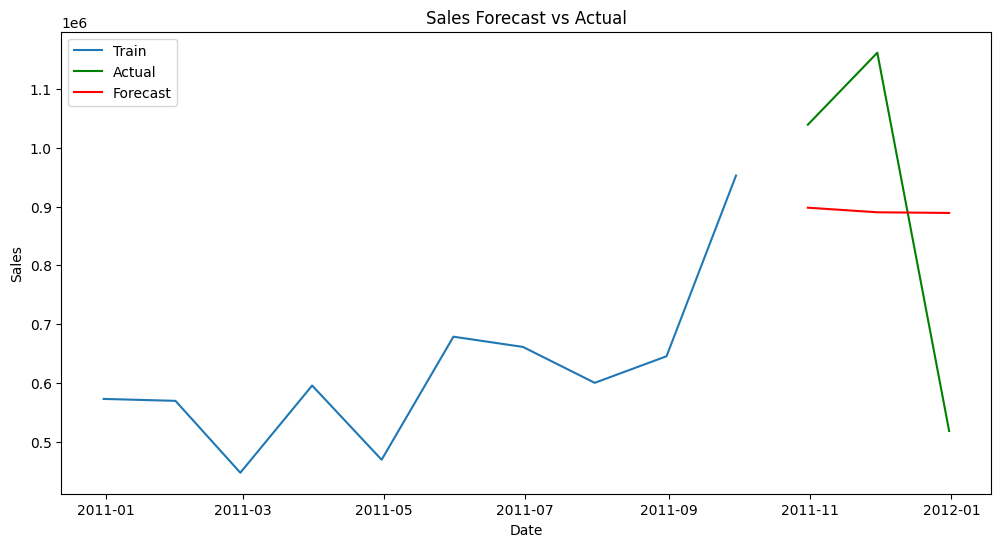

In [26]:
#Visualize Actual vs Forecast
plt.figure(figsize=(12,6))
plt.plot(train.index, train["Sales"], label="Train")
plt.plot(test.index, test["Sales"], label="Actual", color="green")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast", color="red")

plt.title("Sales Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [28]:
#Forecast Next 6 Months (Future Demand)
future_forecast = model_fit.forecast(steps=6)

future_dates = pd.date_range(
    start=ts.index.max() + pd.offsets.MonthEnd(1),
    periods=6,
    freq="M"
)

future_df = pd.DataFrame({
    "Date": future_dates,
    "Forecasted_Sales": future_forecast
})

#check:
future_df



/tmp/ipython-input-3062077589.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(


,Date,Forecasted_Sales
2011-10-31,2012-01-31,898117.170414
2011-11-30,2012-02-29,890308.064975
2011-12-31,2012-03-31,889193.650180
2012-01-31,2012-04-30,889034.615276
2012-02-29,2012-05-31,889011.919866
2012-03-31,2012-06-30,889008.681070


In [29]:
future_df.to_csv("future_sales_forecast.csv", index=False)
forecast_df.to_csv("actual_vs_forecast.csv")


In [30]:
# Business assumptions
lead_time_days = 30          # Supplier lead time
service_level = 1.65         # 95% service level (Z-score)


In [31]:
# Average daily demand
future_df["Daily_Demand"] = future_df["Forecasted_Sales"] / 30
future_df


,Date,Forecasted_Sales,Daily_Demand
2011-10-31,2012-01-31,898117.170414,29937.239014
2011-11-30,2012-02-29,890308.064975,29676.935499
2011-12-31,2012-03-31,889193.650180,29639.788339
2012-01-31,2012-04-30,889034.615276,29634.487176
2012-02-29,2012-05-31,889011.919866,29633.730662
2012-03-31,2012-06-30,889008.681070,29633.622702


In [32]:
# Convert historical monthly sales into approximate daily sales
# This helps us understand daily demand fluctuations
daily_sales = ts["Sales"] / 30

# Calculate standard deviation of daily demand
# This represents demand variability, which is critical for safety stock calculation
demand_std = daily_sales.std()

demand_std


7447.121137926886

In [33]:
# Safety Stock formula:
# Safety Stock = Z-score × Demand Standard Deviation × sqrt(Lead Time)

# Z-score is based on desired service level (95% = 1.65)
# Lead time is the number of days supplier takes to deliver
safety_stock = service_level * demand_std * np.sqrt(lead_time_days)

safety_stock


np.float64(67302.77788931559)

In [34]:
# Reorder Point formula:
# ROP = (Average Daily Demand × Lead Time) + Safety Stock

# This tells us WHEN to place a new order
future_df["Reorder_Point"] = (
    future_df["Daily_Demand"] * lead_time_days
) + safety_stock

future_df


,Date,Forecasted_Sales,Daily_Demand,Reorder_Point
2011-10-31,2012-01-31,898117.170414,29937.239014,965419.948303
2011-11-30,2012-02-29,890308.064975,29676.935499,957610.842864
2011-12-31,2012-03-31,889193.650180,29639.788339,956496.428069
2012-01-31,2012-04-30,889034.615276,29634.487176,956337.393165
2012-02-29,2012-05-31,889011.919866,29633.730662,956314.697755
2012-03-31,2012-06-30,889008.681070,29633.622702,956311.458959


In [35]:
# Optimal Inventory = Forecasted Sales + Safety Stock
# This represents the ideal inventory level to meet demand safely

future_df["Optimal_Inventory"] = (
    future_df["Forecasted_Sales"] + safety_stock
)

future_df


,Date,Forecasted_Sales,Daily_Demand,Reorder_Point,Optimal_Inventory
2011-10-31,2012-01-31,898117.170414,29937.239014,965419.948303,965419.948303
2011-11-30,2012-02-29,890308.064975,29676.935499,957610.842864,957610.842864
2011-12-31,2012-03-31,889193.650180,29639.788339,956496.428069,956496.428069
2012-01-31,2012-04-30,889034.615276,29634.487176,956337.393165,956337.393165
2012-02-29,2012-05-31,889011.919866,29633.730662,956314.697755,956314.697755
2012-03-31,2012-06-30,889008.681070,29633.622702,956311.458959,956311.458959


In [36]:
# Assume current inventory is constant for simulation purposes
# Here we use average forecasted sales as current inventory
current_inventory = future_df["Forecasted_Sales"].mean()

# Inventory Gap shows overstock or understock risk
# Positive gap  → Overstock
# Negative gap  → Understock (stockout risk)
future_df["Inventory_Gap"] = current_inventory - future_df["Optimal_Inventory"]

future_df


,Date,Forecasted_Sales,Daily_Demand,Reorder_Point,Optimal_Inventory,Inventory_Gap
2011-10-31,2012-01-31,898117.170414,29937.239014,965419.948303,965419.948303,-74640.931340
2011-11-30,2012-02-29,890308.064975,29676.935499,957610.842864,957610.842864,-66831.825900
2011-12-31,2012-03-31,889193.650180,29639.788339,956496.428069,956496.428069,-65717.411106
2012-01-31,2012-04-30,889034.615276,29634.487176,956337.393165,956337.393165,-65558.376202
2012-02-29,2012-05-31,889011.919866,29633.730662,956314.697755,956314.697755,-65535.680792
2012-03-31,2012-06-30,889008.681070,29633.622702,956311.458959,956311.458959,-65532.441996


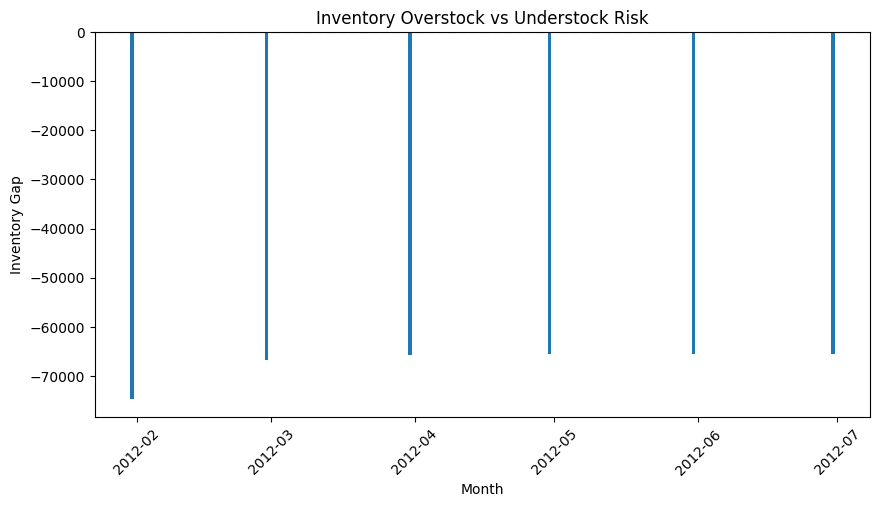

In [37]:
# Bar chart to visualize inventory risk over future months
plt.figure(figsize=(10,5))

# Inventory gap for each future month
plt.bar(future_df["Date"], future_df["Inventory_Gap"])

# Zero line separates overstock and understock zones
plt.axhline(0, color="red", linestyle="--")

plt.title("Inventory Overstock vs Understock Risk")
plt.xlabel("Month")
plt.ylabel("Inventory Gap")
plt.xticks(rotation=45)

plt.show()


In [38]:

future_df.to_csv("inventory_optimization_plan.csv", index=False)
